___
# Air Bnb Price Prediction
### *Author: Aki Taniguchi*
### *Date: 31/01/2020*
___
NB: Great thanks to Blent.AI team and Datagram for providing the opportunity to do this very interesting project, and for providing the AirBnb dataset.  
In order to preserve the intellectual property of the project as a whole, we won't be sharing the dataset on github, and the code here presented is simplified/slightly modified. 

## I. Synopsis
___

Using a number of features scrapped from the Air Bnb website, we will try to predict the price of renting an Air Bnb flat. In order to do so, we will first clean up the data and do some Exploratory Data Analysis as well as Data Visualization to get a better understanding of what it does contain. Price prediction will be achieved using 2 different models: Random Forest and Extreme Gradient Boosting. We will fine-tune the hyperpara-parameters on each model and do a K-fold cross validation to assess the accuracy and its stability so that we can pick-up the best model for this project. Once the most appropriate algorithm is chosen, will try to interpret the interaction between variables using a SHAP model.

## II. Exploratory Data Analysis and Data Visualization
___

In [1]:
# Loading modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import json
import shap

from ipyleaflet import *
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from itertools import product
from scipy.stats.mstats import mquantiles
from sklearn.utils.random import sample_without_replacement

In [60]:
# Loading the datasets
path = 'C:/Users/tngch/Python Code and AI/VS Code/AirBnbProject/airbnb/Dataset/'

listings = pd.read_csv(path + 'listings.csv', sep=';')
amenities = pd.read_json(path_or_buf=path+'amenities.json').set_index('id')
prices = pd.read_csv(path + 'price_availability.csv', sep=';')

Let us see what each dataset contains.

### *II.A. "Listings" dataset*

In [3]:
listings.head()

,listing_id,name,type,city,neighborhood,latitude,longitude,person_capacity,pictures,features,pricing,host_id,host_name,host_data
0,28581061,La maison Clery,private_room,Paris,2e arrondissement,48.869292,2.348335,1,"[""https://a0.muscache.com/im/pictures/668e27ef...","{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 2.0, ""...","{""weekly_factor"": 1.0, ""monthly_factor"": 1.0}",7250,NaN,"{""is_superhost"": false}"
1,661961,studio PARIS PLACE EDITH PIAF 75020,entire_home,Paris,NaN,48.867284,2.403255,2,"[""https://a0.muscache.com/im/pictures/8750975/...","{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}",4905,NaN,"{""is_superhost"": true}"
2,1261705,chambre privée à louer @ paris oberkampf,private_room,Paris,NaN,48.867894,2.375897,1,"[""https://a0.muscache.com/im/pictures/148a0074...","{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 1.0, ""monthly_factor"": 1.0}",3685,NaN,"{""is_superhost"": false}"
3,1318834,Appartement au coeur du Marais,entire_home,Paris,République,48.870370,2.358510,3,"[""https://a0.muscache.com/im/pictures/89598914...","{""beds"": 2, ""bedrooms"": 2, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.82, ""monthly_factor"": 0.48}",5245,NaN,"{""is_superhost"": false}"
4,1677091,Lovely & Quiet flat,entire_home,Paris,Buttes-Chaumont - Belleville,48.874149,2.373700,2,"[""https://a0.muscache.com/im/pictures/a1306610...","{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.95, ""monthly_factor"": 0.9}",3829,NaN,"{""is_superhost"": false}"


In [4]:
listings.describe()

,listing_id,latitude,longitude,person_capacity,host_id,host_name
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,1.543673e+07,48.864251,2.345147,3.668000,4116.899000,NaN
std,9.302042e+06,0.009819,0.031869,2.190108,2280.411517,NaN
min,5.609300e+04,48.844372,2.268992,1.000000,6.000000,NaN
25%,6.346503e+06,48.856930,2.326551,2.000000,2145.250000,NaN
50%,1.727862e+07,48.864405,2.349139,3.000000,4171.000000,NaN
75%,2.378409e+07,48.871875,2.366960,4.000000,6049.000000,NaN
max,2.879280e+07,48.882691,2.412700,16.000000,8118.000000,NaN


In [5]:
print("Shape of the dataframe:", listings.shape)
print("# of missing values:", np.sum(np.sum(listings.isna())))

Shape of the dataframe: (1000, 14)
# of missing values: 1065


In [6]:
np.unique(listings['city'])

array(['*', '-', 'Le Pré-Saint-Gervais', 'Les Lilas', 'Neuilly-sur-Seine',
       'PARIS 3eme', 'Paris', 'Paris 10e Arrondissement',
       'Paris 15e Arrondissement', 'Paris 3e Arrondissement',
       'Paris 4e Arrondissement', 'Paris 4e arrondissement',
       'Paris 6e Arrondissement', 'Paris 7e Arrondissement',
       'Paris 9e Arrondissement', 'Paris city',
       'Paris, Île-de-France, FR', 'Paris-10E-Arrondissement',
       'Paris-11E-Arrondissement', 'Paris-16E-Arrondissement',
       'Paris-17E-Arrondissement', 'Paris-1ER-Arrondissement',
       'Paris-20E-Arrondissement', 'Paris-3E-Arrondissement',
       'Paris-4E-Arrondissement', 'Paris-6E-Arrondissement',
       'Paris-8E-Arrondissement', 'Paris-9E-Arrondissement'], dtype=object)

In [7]:
listings['name'][:20]

0                                       La maison Clery
1                   studio PARIS PLACE EDITH PIAF 75020
2              chambre privée à louer @ paris oberkampf
3                        Appartement au coeur du Marais
4                                   Lovely & Quiet flat
5                   CENTRAL ET BIEN CONÇU,50m2+terrasse
6                         Petit atelier canal st Martin
7     Sophisticated & Sunny Opulent 1BR *Opéra *4 Gu...
8                 Paris 16 - Elysées-Kléber-Trocadero /
9                    GREAT WARM FULL APT LE HAUT MARAIS
10                      UNIQUE ARCHITECT DESIGNED HOUSE
11                    La Maison d'Anne suite 2 chambres
12                          Beau duplex dans le Marais 
13                             Belle Chambre pour court
14               Chambre avec salle de douche privative
15                     stunning studio Charles Laffitte
16    2 Bedroom Parisian Apartment Close to Eiffel T...
17                          chambre à louer pour

For the purpose of this project, we will be mainly focusing on structured data, therefore we will not be using pictures despite their containing potentially useful information which might impact the price of the renting.  
We notice that there are redundant, useless information. First, it seems that the dataset is mostly concentrated in Paris by the look of the "city" feature. This information is surely contained in the location, reflected through the latitude and the longitude, hence we will get rid of it. Likewise, "neighborhood" should be in latitude and longitude, hence a useless feature.  
Second, the "name" feature also contains the location, as well as information contained in either "person_capacity" or "features" (which intuitively makes sense, as the "name" is supposed to be a headline recapping what the host considers to be the most valuable features). We can also get rid of this.  
Finally, we will only use the host data which contains the boolean "is_superhost", which seems to be easier to treat, but also more relevant compared to the "host_id" or "host_name".  

Note we will be dropping irrelevant columns in a later section when preprocessing the dataset.

Let us now have a better visualization on the location by displaying the data on a map.

In [8]:
# Creating an ipyleaflet map centered at Paris
map_to_display = Map(center=(48.86, 2.35), zoom=12)

# We will add pins in our map corresponding to each datapoint in our dataset
coords = listings[['latitude', 'longitude']]
def add_circle(row):
    circle = Circle()
    circle.location = (row['latitude'], row['longitude'])
    circle.radius = 2
    circle.color = 'blue'
    map_to_display.add_layer(circle)
coords.apply(add_circle, axis=1)

# Display map
map_to_display

Map(center=[48.86, 2.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

We can see that our dataset is restricted to few areas in Paris only (it actually is a rectangular shape) but excluding the Paris North and South, with few points in the Western suburbs such as Neuilly-sur-Seine/Auteil/Passy, known to be expensive areas. We should therefore carefully note that our model won't be able to infer rent prices outside this rectangular box.  

Finally, let us take a look at the "features" column:

In [9]:
listings['features'].head()

0    {"beds": 1, "bedrooms": 1, "bathrooms": 2.0, "...
1    {"beds": 1, "bedrooms": 1, "bathrooms": 1.0, "...
2    {"beds": 1, "bedrooms": 1, "bathrooms": 1.0, "...
3    {"beds": 2, "bedrooms": 2, "bathrooms": 1.0, "...
4    {"beds": 1, "bedrooms": 1, "bathrooms": 1.0, "...
Name: features, dtype: object

In [10]:
listings['features'][0]

'{"beds": 1, "bedrooms": 1, "bathrooms": 2.0, "amenity_ids": [33, 4, 21, 8, 40], "is_rebookable": false, "is_new_listing": true, "is_fully_refundable": true, "is_host_highly_rated": false, "is_business_travel_ready": false}'

It contains a string with a list of features in a dictionnary format, where all of them seems important. We note there is an "amenity_ids" feature, which is probably linked to the "amenities" dataframe. In a later stage, we will extract these information into a dataframe and joint it with the "amenities" dataframe.  

To recap, we will only be using the following columns: "listing_id", "type", "latitude", "longitude", "person_capacity", "features" and "pricing", where "features" might be linked with the "amenities" dataframe. We have seen that that there were 1065 missing values, let us make sure there are none in the columns we want to keep.

In [64]:
check_na = listings.drop(['name', 'city', 'neighborhood', 'pictures', 'host_id', 'host_name'], axis=1)
np.sum(np.sum(check_na.isna()))

0

We are safe to proceed with the aformentioned columns for this dataset.

### *II.B. "Amenities" dataset*

Let us look at the information contained in amentities.

In [11]:
amenities.head()

,category,icon,is_business_ready_feature,is_present,is_safety_feature,name,select_list_view_photo,select_tile_view_photo,tag,tooltip
id,,,,,,,,,,
1,NaN,icon-tv,False,True,False,TV,NaN,NaN,tv,
2,NaN,icon-desktop,False,True,False,Cable TV,NaN,NaN,cable,
4,NaN,icon-wifi,False,True,False,Wifi,NaN,NaN,wireless_internet,Continuous access in the listing
5,NaN,icon-air-conditioning,False,False,False,Air conditioning,NaN,NaN,ac,
7,NaN,icon-pool,False,True,False,Pool,NaN,NaN,pool,Private or Shared


In [12]:
print("Shape of the dataframe:", amenities.shape)
print("# of missing values:", np.sum(np.sum(amenities.isna())))

Shape of the dataframe: (102, 10)
# of missing values: 355


In [13]:
len(amenities['name'].unique())

97

A first glance at the data shows that our guess was right, it will be possible to link the features in the "listings" dataset using the amenities_id.  
It seems that we only need the id number, as well as the name of the amenity. However, it looks like there are 5 non-unique names in this dataset.

In [14]:
l = list(amenities['name'])
list({x for x in l if l.count(x) > 1})

['Wide doorway', 'Step-free access']

In [15]:
amenities[(amenities['name'] == 'Wide doorway') | (amenities['name'] == 'Step-free access')]

,category,icon,is_business_ready_feature,is_present,is_safety_feature,name,select_list_view_photo,select_tile_view_photo,tag,tooltip
id,,,,,,,,,,
110,NaN,None,False,True,False,Step-free access,NaN,NaN,home_step_free_access,"There are no steps to get into the home, and t..."
111,NaN,None,False,True,False,Wide doorway,NaN,NaN,home_wide_doorway,The entrance doorway is at least 32 inches wide.
115,NaN,None,False,True,False,Step-free access,NaN,NaN,bedroom_step_free_access,"There are no steps to get into the bedroom, an..."
116,NaN,None,False,True,False,Wide doorway,NaN,NaN,bedroom_wide_doorway,The bedroom door is at least 32 inches wide.
120,NaN,None,False,True,False,Step-free access,NaN,NaN,bathroom_step_free_access,"There are no steps to get into the bathroom, a..."
121,NaN,None,False,True,False,Wide doorway,NaN,NaN,bathroom_wide_doorway,The bathroom door is at least 32 inches wide.
127,NaN,None,False,True,False,Step-free access,NaN,NaN,common_space_step_free_access,There are no steps to get into the common area...


It seems the non-unique features turned out to be "Wide doorway" and "Step-free access", which have multiple ID.  

Let us now make sure there is no missing values in these columns.

In [61]:
np.sum(amenities['name'].isna())

0

No missing values in the "name" column, and there should be no missing values in the ids as they are the row index.  

Within this dataset, we will be keeping "name" column only, and we will be using it to identify which amenities are present in each "listings" observation.   
During preprocessing, we will create an amenity dataset for each Air Bnb flat data point in the "listings" dataset (e.g. we need to have 1000 rows for each flat and 102 columns for each feature). We will make sure to concatenate the above 7 IDs into 2 distinct IDs and bring down the number of feature column to 97.

### *II.C. "Prices" dataset*
Finally, let us look at the "prices" dataset.

In [16]:
prices.head()

,listing_id,day,created,available,local_currency,local_price,min_nights
0,9810829,2018-12-08,2018-09-27 06:14:10.000+0000,True,EUR,160,1
1,9810829,2018-12-08,2018-09-26 19:34:02.000+0000,True,EUR,160,1
2,20897010,2018-12-09,2018-09-27 10:38:57.000+0000,True,EUR,172,2
3,20897010,2018-12-09,2018-09-27 06:10:27.000+0000,True,EUR,172,2
4,20897010,2018-12-09,2018-09-26 19:30:25.000+0000,True,EUR,172,2


In [17]:
print("Shape of the dataframe:", prices.shape)
print("# of missing values:", np.sum(np.sum(prices.isna())))

Shape of the dataframe: (4748696, 7)
# of missing values: 0


In [18]:
prices['local_currency'].unique()

array(['EUR'], dtype=object)

The "prices" dataset only contains location prices in EUR. 
Although an insightful information, the "min_nights" feature which represents the minimum nights of stay for one specific flat might not be a useful in order to predict the renting price.  
Let us now check whether all flats (identified via the listing_id) are contained in this dataset.

In [19]:
l1 = set(prices['listing_id'].unique())
l2 = set(listings['listing_id'].unique())

print(len(l1), len(l2))

11749 1000


There are more flat IDs in the "price" dataset than in the "listings" dataset. Thus, let us make sure that "price" contains all "listings" flat IDs.

In [20]:
included = [x for x in l1 if x in l2]
print("# Identical IDs: ", len(included))

missing = [x for x in l2 if x not in l1]
print("Missing IDs: ", missing)

# Identical IDs:  999
Missing IDs:  [19403332]


It seems like we are missing only one flat ID: #19403332. We will make sure to drop this ID during the preprocessing stage.  
In a second step, let us also look at the date range of our dataset.

In [21]:
prices['day'] = pd.to_datetime(prices['day'], format='%Y-%m-%d')
max_day = max(prices['day'])
min_day = min(prices['day'])

print("[{0}, {1}]".format(min_day.strftime('%Y-%m-%d'), max_day.strftime('%Y-%m-%d')))

interval = (max_day - min_day).days
print("Dataset is contained within {0} days".format(interval))

[2018-08-27, 2019-01-06]
Dataset is contained within 132 days


Our dataset is limited to only 132 days, starting from end of August 2018 to early January 2019. We are missing key dates e.g. spring and summer breaks, but we do have the Christmas/New-Year season.  

Finally, given that the "price" dataset shows the Air Bnb renting price per flat for each day, let us look at the price distribution and if there is any seasonality in the pricing. We will restrict our analysis on flats present in our original "listings" dataframe only, as we won't be doing any regression on the others.

In [22]:
prices[prices['listing_id'].isin(listings['listing_id'])]['local_price'].describe()

count    402616.000000
mean        194.766075
std         191.812037
min           9.000000
25%          78.000000
50%         145.000000
75%         240.000000
max        3302.000000
Name: local_price, dtype: float64

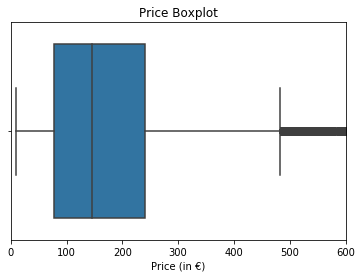

In [23]:
ax = sns.boxplot(prices[prices['listing_id'].isin(listings['listing_id'])]['local_price'])
ax.set(xlim=[0,600], title='Price Boxplot', xlabel='Price (in €)')
plt.show(ax)

We can see that 75 percentile of the prices is contained within 240€, which intuitively makes sense. We do note however that there are few outliers with maximum price at 3,302€, and minimum price 9€.

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()


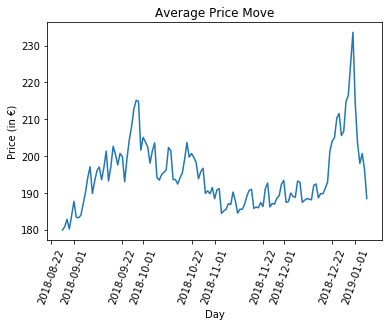

In [24]:
# Looking at the average price move first
mean_df = prices[prices['listing_id'].isin(listings['listing_id'])].groupby(['day']).mean()
mean_df = mean_df.reset_index()
ax = sns.lineplot(x=mean_df['day'], y=mean_df['local_price'])
ax.set(title='Average Price Move', xlabel='Day', ylabel='Price (in €)')
plt.xticks(rotation=70)
plt.show(ax)

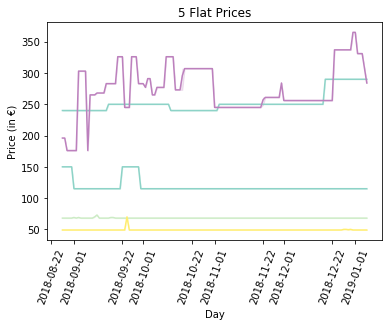

In [25]:
# Randomly picking up 5 flat prices for comparison
np.random.seed(5)
sample = np.random.choice(list(listings['listing_id']), 5)
plot_df = prices[prices['listing_id'].isin(sample)]
fig = sns.lineplot(x="day", y="local_price", hue="listing_id", palette="Set3", data=plot_df)
fig.get_legend().remove()
fig.set(title='5 Flat Prices', xlabel='Day', ylabel='Price (in €)')
plt.xticks(rotation=70)
plt.show(fig)

In average, it is clear that we have a seasonality effect due to the holiday season. In addition, the scissor-like shape of the curve also points to price increase driven by week-end. This pattern is confirmed as we look into more granular pricing at a flat-by-flat level, although in various degree depending on the owner. We can indeed see that some owner are very active in repricing, some others do not change its price at all.  

As a conclusion, we will keep the ID, the price and the date in order to make a junction with the "listings" dataframe. We are safe to proceed given no missing values in this dataset.

## III. Data Preprocessing
___
Now that we have explored and have a preliminary understanding of each dataframe, we need to create a clean and processed final working dataframe to build a model on.  
For that purpose, we will proceed in several steps. First, we will drop useless columns and make a junction between the "listings" dataframe and "prices" dataframe. Then, we will make a second junction between this datagrame and the "amenities" dataframe, so that we have all relevant features for each observation. Lastly, we will study and clean any missing values.

### *III.A. Including prices*

In [26]:
# First junction between "listings" and "prices"
clean_df = pd.merge(listings, prices, on='listing_id', how='inner')
clean_df = clean_df.drop(['name', 'city', 'neighborhood', 'pictures', 'host_id', 'host_name', 'created', 'available',\
                          'local_currency', 'min_nights'], axis=1)

print("# of Prices: {0}, # of columns: {1}".format(clean_df.shape[0], clean_df.shape[1]))
print("# of Flat:", len(clean_df['listing_id'].unique()))

# of Prices: 402616, # of columns: 10
# of Flat: 999


In [27]:
# Making sure we do not have the flat ID #19403332 which doesn't have any price
clean_df[clean_df['listing_id'] == 19403332]

,listing_id,type,latitude,longitude,person_capacity,features,pricing,host_data,day,local_price


Our new dataframe includes prices per day for each IDs. Note that we made an inner junction between 'listings' and 'prices' so that we exclude the flat ID #19403332. We can verify that we dropped 1 flat and we now only have 999 set of prices.  

We will now create 2 new columns to account for the seasonal effect that we previously identified. Concretely speaking, we will add a week-end indicator, and a week number index (as the period of the year is highly impacting the price).

In [28]:
# Adding 2 new columns by first transforming the "day" column into a date object
clean_df['day'] = pd.to_datetime(clean_df['day'], format='%Y-%m-%d')
clean_df['week_number'] = clean_df['day'].dt.week
clean_df['is_weekend'] = np.where(clean_df['day'].dt.dayofweek < 5, 0, 1)
clean_df = clean_df.drop(['day'], axis=1)

clean_df[500:510]

,listing_id,type,latitude,longitude,person_capacity,features,pricing,host_data,local_price,week_number,is_weekend
500,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,43,0
501,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,42,0
502,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,42,1
503,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,44,0
504,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,40,0
505,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",55,35,1
506,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,45,0
507,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,46,1
508,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,46,0
509,661961,entire_home,48.867284,2.403255,2,"{""beds"": 1, ""bedrooms"": 1, ""bathrooms"": 1.0, ""...","{""weekly_factor"": 0.88, ""monthly_factor"": 0.69}","{""is_superhost"": true}",40,40,0


### *III.B. Creating the amenities datatable*
We now need to process and encode the 'features', 'pricing' and 'host_data' column.

In [29]:
# Processing the "amenities" dataframe
amenities = amenities.reset_index()
amenities = amenities[['id', 'name']]
amenities = amenities.rename(columns={'id':'amenity_ids', 'name':'feature_name'})
amenities

,amenity_ids,feature_name
0,1,TV
1,2,Cable TV
2,4,Wifi
3,5,Air conditioning
4,7,Pool
...,...,...
97,287,Paid parking on premises
98,294,Fixed grab bars for shower
99,295,Fixed grab bars for toilet
100,296,Roll-in shower


In [30]:
# Designing a helper function which creates an amenity dataframe for each flat ID
def get_amenities(X, n):
    # Input:
    # X = dictionnary-styled string, e.g. the n-th 'features'-column value of the 'listings' dataframe
    # n = row number of the flat ID
    
    # Output:
    # X = returned the amenity dataframe respective to the input flat ID
    
    
    # As the 'features' column in the 'listings' dataset is a string written as a dictionnary, we use eval() and
    # transform it into a dataframe
    X = eval(X)
    
    # However, we need to keep track if the owner didn't input any amenities at all
    # Indeed, if amenity_ids is empty, this will create error in the code, hence it requires an additional implementation
    # to take care of it
    no_amenities = False
    if X['amenity_ids'] == []:
        X['amenity_ids'].append(1)
        no_amenities = True
    
    # Changing the dictionnary into a dataframe to set up the expanded 'features' dataframe
    X = pd.DataFrame.from_dict(X)
    
    # Add the listing_id so that we can merge the amenities dataframe and the listings dataframe later
    X['listing_id'] = listings['listing_id'][n]
    
    # Merge the original 'amenities' dataframe with the new expanded 'features' dataframe
    X = pd.merge(X, amenities, on='amenity_ids', how='left')
    
    # Transform all features into dummy variables
    X_dummies = pd.get_dummies(X['feature_name'])
    
    # Concatenate the dummy dataframe with the 'features' dataframe
    X = pd.concat([X, X_dummies], axis=1)
    
    # Clean up the dataset by dropping useless column and filling all values in the dummy dataframe by 1
    X = X.drop(['amenity_ids', 'feature_name'], axis=1)
    X.iloc[:, 9:X.shape[1]] = 1
    
    # Get only the first row which contains all the necessary information
    X = X.iloc[:1,:]

    # Finalize the dataframe with the 3 features left (also presented as a dictionnary-style string)
    X['weekly_factor'] = eval(listings['pricing'][n])['weekly_factor']
    X['monhtly_factor'] = eval(listings['pricing'][n])['monthly_factor']
    X['is_superhost'] = eval(listings['host_data'][n])['is_superhost']
    
    if no_amenities == True:
        # Amenity TV corresponds to the ID 1 which we appended earlier
        X['TV'] = 0
    
    return X

In [31]:
# Second helper function that concatenates two dataframes, and fill missing values with 0
# This helps add features which were missing in the previous dataframe (which generates NAs on their respective values)
# Note that this concatenation helps dealing with the 2 repeated features, namely "Wide doorway" and "Step-free access"
def merge_row(x1, x2):
    # Input:
    # x1 = First dataframe to concatenate
    # x2 = Second dataframe to concatenate
    
    # Output:
    # X = Concatenated dataframe with NA filled with 0
    
    X = pd.concat([x1, x2], axis=0, sort=False)
    X = X.fillna(0)
    
    return X

In [32]:
# Replacing true/false string into 1/0 to perform a preliminary encoding
listings = listings.replace({'[tT]rue': '1', '[fF]alse': '0'}, regex=True)

for i in range(0, listings.shape[0]):
    # Apply the helper function get_amenities to create the 'features' dataframe
    if i == 0:
        # Initialization of the new 'amenities' dataframe
        all_features = get_amenities(listings['features'][i], i)
    else:
        # Once initialized, we merge dataframes as we loop through the listing IDs
        all_features = merge_row(all_features, get_amenities(listings['features'][i], i))

all_features = all_features.reset_index().drop(['index'], axis=1)
all_features

,beds,bedrooms,bathrooms,is_rebookable,is_new_listing,is_fully_refundable,is_host_highly_rated,is_business_travel_ready,listing_id,Elevator,...,Smart lock,Accessible-height bed,Roll-in shower,Disabled parking spot,Handheld shower head,"Wide clearance to shower, toilet",Accessible-height toilet,Fixed grab bars for toilet,Bathtub with bath chair,Beach essentials
0,1.0,1.0,2.0,0,1,1,0,0,28581061,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0,0,1,1,0,661961,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0,0,1,1,0,1261705,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,2.0,1.0,0,0,1,0,0,1318834,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0,0,1,1,0,1677091,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,1.0,0,1,1,0,0,28335197,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,1.0,1.0,1.0,0,1,1,0,0,28583013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,2.0,1.0,1.0,0,1,1,1,0,28628316,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,4.0,2.0,1.5,0,1,1,0,0,28792796,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print("# of unique IDs:", len(all_features['listing_id'].unique()))
print("Shape of the new 'amenities' dataframe:", all_features.shape)

# of unique IDs: 1000
Shape of the new 'amenities' dataframe: (1000, 103)


We now have a new 'amenities' dataset indexed by listing_id, which matches the listing_id in the 'listings' dataset. Before making any junction however, let us verify whether there is any misencoding (categorical column containing values other than 0 or 1). Note that there should not be any useless column (e.g. categorical column filled with 0), as we one-hot encoded each flat ID based on the listed amenities. This is also why we should not have same number of categorical column as unique amenities name.

In [34]:
not_one = []
is_zero = []
for i in range(9, all_features.shape[1]):
    # In order to find out misencoded columns, we sum the entire column and divide by the total number of time the ID
    # is encoded with 1. The division should be equal to 1, otherwise there might be an issue which we will investigate
    if all_features.iloc[:, i].sum(axis=0) / len(all_features[all_features.iloc[:, i] == 1].count(axis=1)) != 1:
        not_one.append(i)
    if all_features.iloc[:, i].sum(axis=0) == 0:
        is_zero.append(i)

print("Column where we might have a misencoding:", not_one)
print("Useless column:", is_zero)

Column where we might have a misencoding: [14, 15]
Useless column: []


In [35]:
for col in not_one:
    print(all_features.columns[col])

weekly_factor
monhtly_factor


It is clear that we do not have any misencoding, nor any useless column. Our dataset is now ready to be merged with the clean dataframe.

### *III.C. Final Clean dataset*

In [36]:
# Merging the 2 datasets
clean_df = pd.merge(clean_df, all_features, on='listing_id', how='left')
room_type = pd.get_dummies(clean_df['type'])
clean_df = pd.concat([clean_df, room_type], sort=True, axis=1)
clean_df = clean_df.drop(['listing_id', 'features', 'pricing', 'host_data', 'type'], axis=1)

clean_df

,latitude,longitude,person_capacity,local_price,week_number,is_weekend,beds,bedrooms,bathrooms,is_rebookable,...,Disabled parking spot,Handheld shower head,"Wide clearance to shower, toilet",Accessible-height toilet,Fixed grab bars for toilet,Bathtub with bath chair,Beach essentials,entire_home,private_room,shared_room
0,48.869292,2.348335,1,47,43,1,1.0,1.0,2.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,48.869292,2.348335,1,47,43,1,1.0,1.0,2.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,48.869292,2.348335,1,47,43,1,1.0,1.0,2.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,48.869292,2.348335,1,47,35,1,1.0,1.0,2.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
4,48.869292,2.348335,1,47,35,1,1.0,1.0,2.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402611,48.875425,2.395240,2,40,42,0,1.0,1.0,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
402612,48.875425,2.395240,2,39,42,0,1.0,1.0,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
402613,48.875425,2.395240,2,39,37,0,1.0,1.0,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
402614,48.875425,2.395240,2,39,37,0,1.0,1.0,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [37]:
print("# of missing values:", np.sum(np.sum(clean_df.isna())))

# of missing values: 0


Our dataset is now clean and we are ready to work on a machine learning algorithm.

## IV. Machine Learning algorithm
___
As we are dealing with a price prediction, we will use a regression algorithm. As the data is light and not too complex, it seems that we don't need to use any neural network, hence we will be using classical Machine Learning models a.k.a Random Forest and Extreme Gradient Boosting. We will fine tune both model, cross-validate them using scikit learn K-fold and compare their accuracy.  
Given that we are dealing with a regression, our accuracy metric will be the $R^{2}$ score.

### *IV.A. Random Forest*
Let us first prepare the data by splitting it into train-test sets.  
Due to the limited amout of observation (only 999 flat IDs, although we do have one price per day for 132 days), note that it is preferable to not split even further into Train-Test-Validation as this might hinder the model quality.
Hence, we will be training our model on 80% of the data (799 ID) and validate our model with the remaining 20% (200 ID).

In [38]:
X = clean_df.drop(['local_price'], axis=1)
y = clean_df['local_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=562)

In [39]:
# Sanity check
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (322092, 110)
X_test shape: (80524, 110)
y_train shape: (322092,)
y_test shape: (80524,)


Now that we have our data split, we are ready to implement the first model. As a starting point, we will set the hyper-parameters as follows: 
 - We will create 100 different trees. This number is big enough to start with.
 - We will use a maximum depth of 9 level. We don't want to start with potentially deep trees as we just want to have an initial idea of the model performance.
 - The number of points in each external node should be at least 10.
 - For any internal node, we will require at least 3 samples before splitting the node.
 - We won't be using any random subset of features, just bagging the 300 trees altogether.
 - We will not allow any bootstrapping to begin with.

In [40]:
# Setting the base hyper-parameters
hyper_parameter = {
    'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 10,
    'max_features': 'auto','bootstrap': False
}

# Training the base model
rf_model = RandomForestRegressor(**hyper_parameter)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=9,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [41]:
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

print("Train Accuracy : {:2.1f}%".format(r2_score(y_train, y_pred_train) * 100))
print("Test Accuracy : {:2.1f}%".format(r2_score(y_test, y_pred_test) * 100))

Train Accuracy : 82.2%
Test Accuracy : 81.5%


Using our initial tuning, the random forest algorithm returns an accuracy of 82%, with a low variance between Train and test of 0.7% (this was excepted due to the bagging effect of the Random Forest). Although the Variance level is acceptable, the overall Bias level is still too low. We will try to improve the score by fine-tuning our model using a grid-based K-fold Cross Validation.

####  Fine-tuning and K-fold Cross Validation
Let us first design the hyper-parameter grid to work on. For simplicity sake, we have kept the grid light.

In [42]:
hyper_parameter_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [10],    
    'max_features': ['auto'],
    'bootstrap': [False]
}

# Creating the hyper-parameter list for dictionnary comprehension
hyper_parameter_list = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'bootstrap']

We now have to run the random forest model for each set of hyper-parameter, based on a random split of our dataset into K-fold Train/Test set. Note however that we do not have a large dataset, therefore we cannot have a lot of fold (e.g. the value of k). For 999 IDs, setting k=3 seems reasonable. With the train-test ratio set to 80%/20% and having 3 folds, each Train/Test folds should contain 266/67 IDs respectively, which should be acceptable.

In [43]:
# Defining the dictionnary containing the result of our Cross Validation
cv_result = {
    'parameters_set': [],
    'train_accuracy': [],
    'test_accuracy': []
}


# We run a grid-based K-fold cross-validation and input the result in the cv_result variable
for parameters_set in product(*hyper_parameter_grid.values()):
    
    # Initialize the K-fold object with 3 folds, and 2 lists which will contain the accuracy of each Train/Test-fold set
    # Note that we will compute their average which will represent the overall Train/Test accuracy for the parameter set
    kfold = KFold(n_splits=3, shuffle=True)
    train_accuracy = []
    test_accuracy = []

    # Split our original dataset X and y into Train/Test based on the K-fold object, fit the Random Forest model
    # and compute each accuracy
    for train_I, test_I in kfold.split(X):
        # Train/Test split
        X_fold = X.iloc[train_I, :]
        y_fold = y.values[train_I]
        X_fold_train, X_fold_test, y_fold_train, y_fold_test = train_test_split(X_fold, y_fold, test_size=0.2)

        # Set the hyper-parameters
        hyper_parameter = {param:val for param, val in zip(hyper_parameter_list, parameters_set)}
        
        # Model fitting
        rf_model = RandomForestRegressor(**hyper_parameter)
        rf_model.fit(X_fold_train, y_fold_train)
        
        # Calculate the model accuracy
        train_accuracy.append(round(r2_score(y_fold_train, rf_model.predict(X_fold_train))*100, 2))
        test_accuracy.append(round(r2_score(y_fold_test, rf_model.predict(X_fold_test))*100, 2))

    
    # Allocate the result in the cv_result variable
    cv_result['parameters_set'].append(parameters_set)
    cv_result['train_accuracy'].append(np.mean(train_accuracy))
    cv_result['test_accuracy'].append(np.mean(test_accuracy))

Now that we have run the model for each set of parameters, let us display each accuracy.

In [44]:
cv_result = pd.DataFrame.from_dict(cv_result)
cv_result['bias'] = 100 - cv_result['train_accuracy']
cv_result['variance'] = cv_result['train_accuracy'] - cv_result['test_accuracy']
cv_result['bias-variance ratio'] = abs(cv_result['variance'] / cv_result['bias'])
cv_result = cv_result.sort_values(by=['bias', 'bias-variance ratio'])

cv_result

,parameters_set,train_accuracy,test_accuracy,bias,variance,bias-variance ratio
10,"(100, 11, 2, 10, auto, False)",88.600000,88.066667,11.400000,0.533333,0.046784
11,"(100, 11, 5, 10, auto, False)",88.373333,87.740000,11.626667,0.633333,0.054472
16,"(300, 11, 2, 10, auto, False)",88.330000,87.693333,11.670000,0.636667,0.054556
17,"(300, 11, 5, 10, auto, False)",88.050000,87.323333,11.950000,0.726667,0.060809
5,"(50, 11, 5, 10, auto, False)",87.980000,87.676667,12.020000,0.303333,0.025236
4,"(50, 11, 2, 10, auto, False)",87.926667,87.470000,12.073333,0.456667,0.037824
2,"(50, 9, 2, 10, auto, False)",82.243333,82.206667,17.756667,0.036667,0.002065
14,"(300, 9, 2, 10, auto, False)",82.026667,81.840000,17.973333,0.186667,0.010386
3,"(50, 9, 5, 10, auto, False)",82.003333,82.030000,17.996667,-0.026667,0.001482
8,"(100, 9, 2, 10, auto, False)",81.943333,81.830000,18.056667,0.113333,0.006277


We define the bias being how far does the model deviate from the target (100% precision), e.g. 100% - Train_accuracy, and the variance being how sparse the model is, e.g. Train_accuracy - Test_accuracy.  
We also define the best model being the model which has the least bias and the least variance. However, when the bias and variance are similar, we determine the best model using the "bias-variance" ratio. Dividing the variance by the bias gives the proportional distance between the 2, and the model having the smallest distance should be the best.  

Based on the above, we can see that the best parameters set are 100 trees, with a depth of 11 level, with 2 samples at minimum on every leaf.

#### Model Stability
Now that we have the best hyper-parameter set, let us test how stable our model is. In other words, we need to make sure that there is no big variance in the accuracy of the model. To do so, we will use the K-fold splitting method (with k=30), and run the model for each fold. This should give us the distribution of the accuracy which will enable us to infer the stability of the model based on a 95 percentile confidence interval.

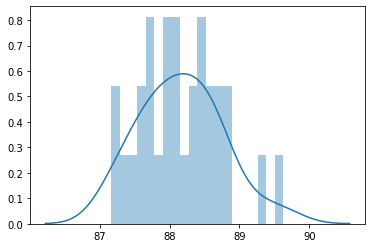

In [45]:
# Initialize variables (with k=30)
kfold = KFold(n_splits=30, shuffle=True)
model_test_accuracy = []

# Split our original dataset X and y into Train/Test based on the K-fold object, fit the Random Forest model
# and compute each accuracy
for train_I, test_I in kfold.split(X):
    # Train/Test split
    X_fold = X.iloc[train_I, :]
    y_fold = y.values[train_I]
    X_fold_train, X_fold_test, y_fold_train, y_fold_test = train_test_split(X_fold, y_fold, test_size=0.2)

    # Set the hyper-parameters
    hyper_parameter = {
        'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 10,
        'max_features': 'auto','bootstrap': False
    }
        
    # Model fitting
    rf_model = RandomForestRegressor(**hyper_parameter)
    rf_model.fit(X_fold_test, y_fold_test)
        
    # Calculate the model accuracy
    model_test_accuracy.append(r2_score(y_fold_test, rf_model.predict(X_fold_test))*100)

# Plot the distribution of the model accuracy
sns.distplot(model_test_accuracy, bins=20)

In [46]:
CI = mquantiles(model_test_accuracy, [0.025, 0.975])
print("Model Accuracy 95 percentile Confidence Interval: {0}".format(CI))

Model Accuracy 95 percentile Confidence Interval: [87.17342187 89.57384387]


Running the model with 30 smaller datasets after a random shuffling gives a 95 percentile confidence interval of 2.4% variance. We can therefore conclude that the model is fairly stable. However, the best accuracy is still low at 89.6%, and there is certainly enough room for improvement. We will now try to model a boosting model which should improve the accuracy at the expense of some variance.

### *IV.C. XGBoost*
We will follow the exact same scheme as we did for Random Forest modelling. Let us have an initial overview of the model performance, by setting the base hyper-parameters as follows:
 - The learning rate (or the ETA) will be set to 0.5
 - The maximum depth will be 6 levels. As opposed to Random Forest, XGBoost is more likely to overfit, therefore we want to keep the model as simple as possible.
 - We will set the number of trees to be 20.
 - As we are working on a regression task, the objective should be 'reg:squarederror'.

We will be carefully studying the variance between Train and Test so that we can implement a regularization to prevent any possible overfitting (e.g. $\alpha$, $\lambda$, $\gamma$).

In [47]:
# Setting the base hyper-parameters
hyper_parameter = {
    'eta':0.5, 'n_estimators': 20, 'max_depth':6, 'objective':'reg:squarederror'
}

# Training the base model
xgb_model = xgb.XGBRegressor(**hyper_parameter)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.5, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [48]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

print("Train Accuracy : {:2.1f}%".format(r2_score(y_train, y_pred_train) * 100))
print("Test Accuracy : {:2.1f}%".format(r2_score(y_test, y_pred_test) * 100))

Train Accuracy : 93.2%
Test Accuracy : 92.7%


We can see that the model is a lot more accurate than Random Forest, as we have greatly reduced the bias (from 88.4% to 93.2% on the training set), though we have lost some variance (from 0.7% to 1.5%) in the bias-variance trade-off. The pick up in variance is acceptable as it is still at a low level, therefore XGBoost should be preferred to Random Forest.  
We will now try to further improve the model performance by fine-tuning it.

#### Fine tuning with K-fold Cross Validation
Likewise, we will fine-tune the model using a grid of hyper-parameters.

In [49]:
hyper_parameter_grid = {
    'eta': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7],
    'objective': ['reg:squarederror']
}

# Creating the hyper-parameter list for dictionnary comprehension
hyper_parameter_list = ['eta', 'n_estimators', 'max_depth', 'objective']

In [50]:
# Defining the dictionnary containing the result of our Cross Validation
cv_result = {
    'parameters_set': [],
    'train_accuracy': [],
    'test_accuracy': []
}


# We run a grid-based K-fold cross-validation and input the result in the cv_result variable
for parameters_set in product(*hyper_parameter_grid.values()):
    
    # Initialize the K-fold object with 3 folds, and 2 lists which will contain the accuracy of each Train/Test-fold set
    # Note that we will compute their average which will represent the overall Train/Test accuracy for the parameter set
    kfold = KFold(n_splits=3, shuffle=True)
    train_accuracy = []
    test_accuracy = []

    # Split our original dataset X and y into Train/Test based on the K-fold object, fit the Random Forest model
    # and compute each accuracy
    for train_I, test_I in kfold.split(X):
        # Train/Test split
        X_fold = X.iloc[train_I, :]
        y_fold = y.values[train_I]
        X_fold_train, X_fold_test, y_fold_train, y_fold_test = train_test_split(X_fold, y_fold, test_size=0.2)

        # Set the hyper-parameters
        hyper_parameter = {param:val for param, val in zip(hyper_parameter_list, parameters_set)}
        
        # Model fitting
        xgb_model = xgb.XGBRegressor(**hyper_parameter)
        xgb_model.fit(X_fold_train, y_fold_train)
        
        # Calculate the model accuracy
        train_accuracy.append(round(r2_score(y_fold_train, xgb_model.predict(X_fold_train))*100, 2))
        test_accuracy.append(round(r2_score(y_fold_test, xgb_model.predict(X_fold_test))*100, 2))

    
    # Allocate the result in the cv_result variable
    cv_result['parameters_set'].append(parameters_set)
    cv_result['train_accuracy'].append(np.mean(train_accuracy))
    cv_result['test_accuracy'].append(np.mean(test_accuracy))

In [51]:
cv_result = pd.DataFrame.from_dict(cv_result)
cv_result['bias'] = 100 - cv_result['train_accuracy']
cv_result['variance'] = cv_result['train_accuracy'] - cv_result['test_accuracy']
cv_result['bias-variance ratio'] = abs(cv_result['variance'] / cv_result['bias'])
cv_result = cv_result.sort_values(by=['bias', 'bias-variance ratio'])

cv_result

,parameters_set,train_accuracy,test_accuracy,bias,variance,bias-variance ratio
8,"(0.1, 400, 7, reg:squarederror)",97.383333,96.946667,2.616667,0.436667,0.166879
5,"(0.1, 200, 7, reg:squarederror)",96.663333,96.466667,3.336667,0.196667,0.058941
7,"(0.1, 400, 5, reg:squarederror)",95.826667,95.310000,4.173333,0.516667,0.123802
2,"(0.1, 100, 7, reg:squarederror)",95.140000,94.760000,4.860000,0.380000,0.078189
4,"(0.1, 200, 5, reg:squarederror)",93.553333,93.630000,6.446667,-0.076667,0.011892
17,"(0.01, 400, 7, reg:squarederror)",91.096667,91.330000,8.903333,-0.233333,0.026207
1,"(0.1, 100, 5, reg:squarederror)",89.913333,89.806667,10.086667,0.106667,0.010575
6,"(0.1, 400, 3, reg:squarederror)",89.890000,89.743333,10.110000,0.146667,0.014507
3,"(0.1, 200, 3, reg:squarederror)",84.150000,83.796667,15.850000,0.353333,0.022292
16,"(0.01, 400, 5, reg:squarederror)",82.953333,82.540000,17.046667,0.413333,0.024247


After fine-tuning, we improved the performance of our model from 92.7% to 96.9% on test data, with a limited variance of 0.4%. It is quite clear that the XGB model is performing a lot better compared to Random Forest but we still need to double check its stability through a cross-validation.

#### Model Stability
Likewise, we will assess the model stability based on the best set of parameters we have found.

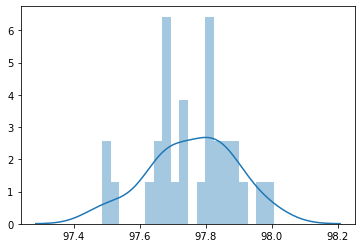

In [52]:
# Initialize variables (with k=30)
kfold = KFold(n_splits=30, shuffle=True)
model_test_accuracy = []

# Split our original dataset X and y into Train/Test based on the K-fold object, fit the Random Forest model
# and compute each accuracy
for train_I, test_I in kfold.split(X):
    # Train/Test split
    X_fold = X.iloc[train_I, :]
    y_fold = y.values[train_I]
    X_fold_train, X_fold_test, y_fold_train, y_fold_test = train_test_split(X_fold, y_fold, test_size=0.2)

    # Set the hyper-parameters
    hyper_parameter = {
        'eta':0.1, 'n_estimators': 400, 'max_depth':7, 'objective':'reg:squarederror'
    }
        
    # Model fitting
    xgb_model = xgb.XGBRegressor(**hyper_parameter)
    xgb_model.fit(X_fold_test, y_fold_test)
        
    # Calculate the model accuracy
    model_test_accuracy.append(r2_score(y_fold_test, xgb_model.predict(X_fold_test))*100)

# Plot the distribution of the model accuracy
sns.distplot(model_test_accuracy, bins=20)
plt.show()

In [53]:
CI = mquantiles(model_test_accuracy, [0.025, 0.975])
print("Model Accuracy 95 percentile Confidence Interval: {0}".format(CI))

Model Accuracy 95 percentile Confidence Interval: [97.49001219 98.00152552]


The model is highly accurate (98%), stable with a narrow confidence interval (0.6%). We have found the best model fitted for this exercise.

## V. Model Explanation
___
Now that we have chosen our model, let us try and understand how does it evaluate each features.

In [71]:
final_model = xgb.XGBRegressor(eta=0.1, n_estimators=400, max_depth=7, objective='reg:squarederror')
final_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(final_model, feature_perturbation='tree_path_dependent')
X_shap = X.iloc[sample_without_replacement(X.shape[0], int(X.shape[0] * 0.05)), :]
shap_values = explainer.shap_values(X_shap)

shap.initjs()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


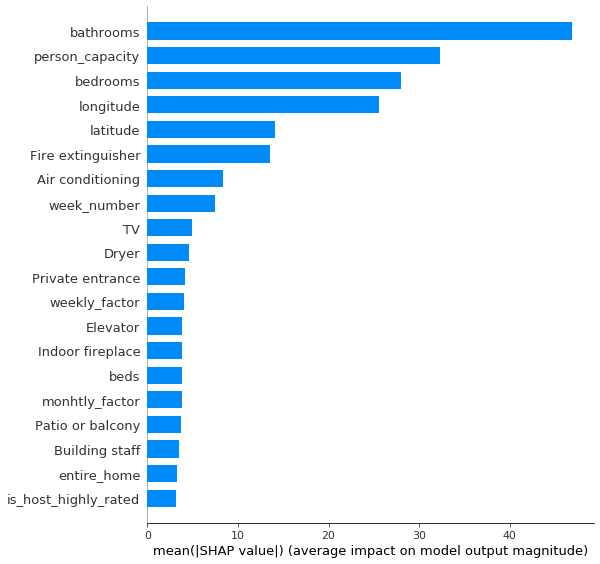

In [72]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

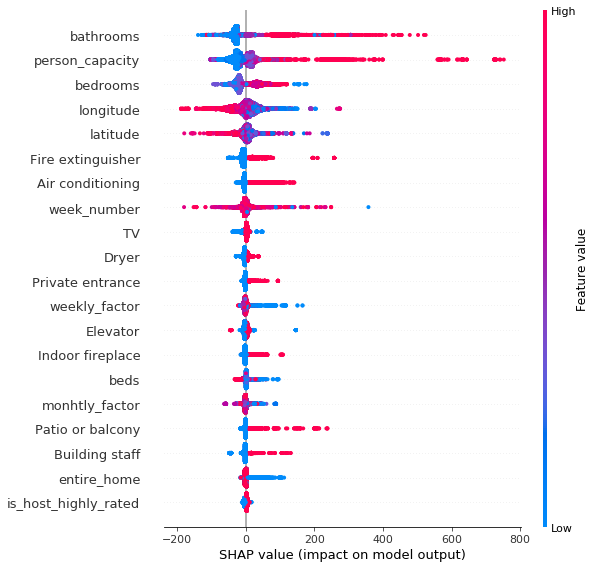

In [73]:
shap.summary_plot(shap_values, X_shap)

Interestingly, it seems that the features which relates to the area of the house are the most important features, e.g. "# bathrooms", "person capacity", "bedrooms". We can see from the summary plot that the more their value increases, the higher the price. , which is intuitively correct.

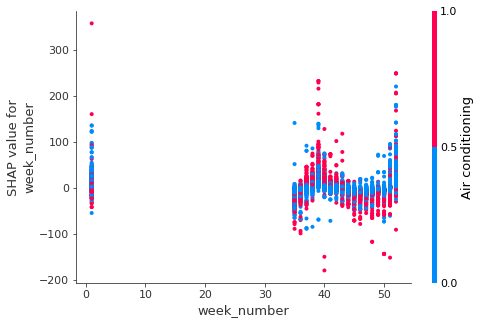

In [74]:
shap.dependence_plot('week_number', shap_values, X_shap)

Looking at the seasonality of the model, we can see that it captures very well the surge in price effective during the Christmas/New Year season.

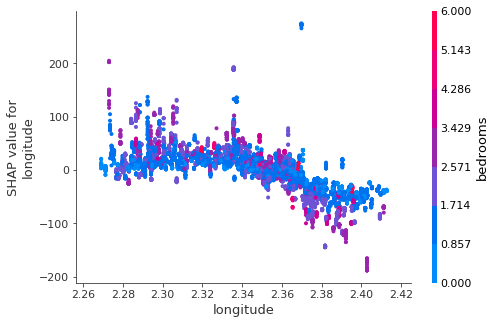

In [75]:
shap.dependence_plot('longitude', shap_values, X_shap)

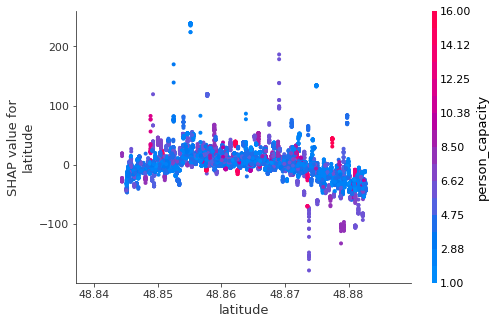

In [76]:
shap.dependence_plot('latitude', shap_values, X_shap)

Finally, although it seems that the price has a tendency to go upward when going south and/or west (e.g. lower latitude and longitude respectively), the pattern is not clear enough for us to strongly conclude. This is perhaps due to the interdependency with other variables (e.g. bigger house to rent in the north drives prices higher).  

After an in-depth look at the SHAP value resulting from the XGBmodel, we have seen that most of the variable interaction makes sense intuitively. Indeed, the seasonality that we witnessed during the data exploration phase is well captured in the model, and there is a strong and positive correlation between area features and the price, which is intuitively correct. The location was more mixed as no clear pattern could be seen, but it remains nonetheless one of the most prominent factor in deciding the renting price.

## VI. Conclusion
___
Starting from a base dataset scrapped from the Airbnb website (thanks to Datagram and Blent.AI team), we explored, cleaned up and processed it so that we could fit a machine learning algorithm to predict the renting price. During the data exploration phase, we noticed several constrains in our dataset, such as: we are in a presence of a small data (with only 1000 different type of IDs), we are working only on a selected area in Paris (even not Paris in a whole) and the first semester of the year seems missing. Having these limitations in mind, we have seen that there was a clear seasonal pattern in the price that we made sure got reflected in our final model.  
Once we got rid of all unnecessary features and came up with one final clean dataset, we ran several machine learning models, namely Random Forest and Extreme Gradient Boosting. A thouroughful fine-tuning and a k-fold cross-validation (with k=30) showed us that the best model to retain was XGBoost, which achieved an accuracy as high as 96.9% on the test set, with a limited variance of 0.4%.  
Looking more carefully at what the model is doing, we have been able to confirm that the seasonality was indeed reflected, and the area-linked features were the most important variables that influence the price. It seems that we could be further reducing down the number of features which are not really useful in predicting the price, without hurting the performance of the model much.